In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import category_encoders as ce

from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import CategoricalNB, BernoulliNB, MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from datetime import datetime



#import plotly.graph_objects as go
#from nltk.corpus import stopwords


In [2]:
df = pd.read_csv("US_Accidents.csv")
df.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,3,2/8/2016 0:37,2/8/2016 6:37,40.108910,-83.092860,40.112060,-83.031870,3.230,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,2,2/8/2016 5:56,2/8/2016 11:56,39.865420,-84.062800,39.865010,-84.048730,0.747,At OH-4/OH-235/Exit 41 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-3,2,2/8/2016 6:15,2/8/2016 12:15,39.102660,-84.524680,39.102090,-84.523960,0.055,At I-71/US-50/Exit 1 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Day
3,A-4,2,2/8/2016 6:51,2/8/2016 12:51,41.062130,-81.537840,41.062170,-81.535470,0.123,At Dart Ave/Exit 21 - Accident.,...,False,False,False,False,False,False,Night,Night,Day,Day
4,A-5,3,2/8/2016 7:53,2/8/2016 13:53,39.172393,-84.492792,39.170476,-84.501798,0.500,At Mitchell Ave/Exit 6 - Accident.,...,False,False,False,False,False,False,Day,Day,Day,Day


In [3]:
# Cast Start_Time to datetime
df["Start_Time"] = pd.to_datetime(df["Start_Time"], errors ='coerce')

# Extract year, month, weekday and day
df["Year"] = df["Start_Time"].dt.year
df["Month"] = df["Start_Time"].dt.month
df["Weekday"] = df["Start_Time"].dt.weekday
df["Day"] = df["Start_Time"].dt.day

# Extract hour and minute
df["Hour"] = df["Start_Time"].dt.hour
df["Minute"] = df["Start_Time"].dt.minute

df.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Year,Month,Weekday,Day,Hour,Minute
0,A-1,3,2016-02-08 00:37:00,2/8/2016 6:37,40.108910,-83.092860,40.112060,-83.031870,3.230,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,...,Night,Night,Night,Night,2016.0,2.0,0.0,8.0,0.0,37.0
1,A-2,2,2016-02-08 05:56:00,2/8/2016 11:56,39.865420,-84.062800,39.865010,-84.048730,0.747,At OH-4/OH-235/Exit 41 - Accident.,...,Night,Night,Night,Night,2016.0,2.0,0.0,8.0,5.0,56.0
2,A-3,2,2016-02-08 06:15:00,2/8/2016 12:15,39.102660,-84.524680,39.102090,-84.523960,0.055,At I-71/US-50/Exit 1 - Accident.,...,Night,Night,Night,Day,2016.0,2.0,0.0,8.0,6.0,15.0
3,A-4,2,2016-02-08 06:51:00,2/8/2016 12:51,41.062130,-81.537840,41.062170,-81.535470,0.123,At Dart Ave/Exit 21 - Accident.,...,Night,Night,Day,Day,2016.0,2.0,0.0,8.0,6.0,51.0
4,A-5,3,2016-02-08 07:53:00,2/8/2016 13:53,39.172393,-84.492792,39.170476,-84.501798,0.500,At Mitchell Ave/Exit 6 - Accident.,...,Day,Day,Day,Day,2016.0,2.0,0.0,8.0,7.0,53.0


In [4]:
#dropping redundant and unecessary features
drop_features = ["ID", "Start_Time", "End_Time", "End_Lat", "End_Lng", "Description", "Number", "Street", "County", "State", "Zipcode", "Country", "Timezone", "Airport_Code", "Weather_Timestamp", "Wind_Chill(F)", "Turning_Loop", "Sunrise_Sunset", "Nautical_Twilight", "Astronomical_Twilight"]
df =df.drop(drop_features, axis=1)
df.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Side,City,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),...,Stop,Traffic_Calming,Traffic_Signal,Civil_Twilight,Year,Month,Weekday,Day,Hour,Minute
0,3,40.108910,-83.092860,3.230,R,Dublin,42.1,58.0,29.76,10.0,...,False,False,False,Night,2016.0,2.0,0.0,8.0,0.0,37.0
1,2,39.865420,-84.062800,0.747,R,Dayton,36.9,91.0,29.68,10.0,...,False,False,False,Night,2016.0,2.0,0.0,8.0,5.0,56.0
2,2,39.102660,-84.524680,0.055,R,Cincinnati,36.0,97.0,29.70,10.0,...,False,False,False,Night,2016.0,2.0,0.0,8.0,6.0,15.0
3,2,41.062130,-81.537840,0.123,R,Akron,39.0,55.0,29.65,10.0,...,False,False,False,Night,2016.0,2.0,0.0,8.0,6.0,51.0
4,3,39.172393,-84.492792,0.500,R,Cincinnati,37.0,93.0,29.69,10.0,...,False,False,False,Day,2016.0,2.0,0.0,8.0,7.0,53.0


In [5]:
#dropping duplicates
print("Number of rows:", len(df.index))
df.drop_duplicates(inplace=True)
print("Number of rows after drop of duplicates:", len(df.index))

Number of rows: 1048575
Number of rows after drop of duplicates: 1005796


In [6]:
df["Side"].value_counts()


R    826841
L    178955
Name: Side, dtype: int64

In [7]:
df = df[df["Side"] != " "]
df["Side"].value_counts()

R    826841
L    178955
Name: Side, dtype: int64

In [8]:
df[["Pressure(in)", "Visibility(mi)"]].describe().round(2)

,Pressure(in),Visibility(mi)
count,987770.00,983946.00
mean,29.52,9.19
std,0.99,2.58
min,0.02,0.00
25%,29.37,10.00
50%,29.84,10.00
75%,30.01,10.00
max,58.16,140.00


In [9]:
df = df[df["Pressure(in)"] != 0]
df = df[df["Visibility(mi)"] != 0]
df[["Pressure(in)", "Visibility(mi)"]].describe().round(2)

,Pressure(in),Visibility(mi)
count,986640.00,982815.00
mean,29.52,9.20
std,0.99,2.56
min,0.02,0.06
25%,29.37,10.00
50%,29.84,10.00
75%,30.01,10.00
max,58.16,140.00


In [10]:
df_weather = df["Weather_Condition"].unique()

print(len(df_weather))
print(df_weather)

102
['Light Rain' 'Overcast' 'Mostly Cloudy' 'Snow' 'Light Snow' 'Cloudy' nan
 'Scattered Clouds' 'Clear' 'Partly Cloudy' 'Light Freezing Drizzle'
 'Light Drizzle' 'Haze' 'Rain' 'Heavy Rain' 'Fair' 'Drizzle' 'Fog'
 'Thunderstorms and Rain' 'Patches of Fog' 'Light Thunderstorms and Rain'
 'Mist' 'Rain Showers' 'Light Rain Showers' 'Heavy Drizzle' 'Smoke'
 'Light Freezing Fog' 'Light Freezing Rain' 'Blowing Snow'
 'Heavy Thunderstorms and Rain' 'Heavy Snow' 'Snow Grains' 'Squalls'
 'Light Fog' 'Shallow Fog' 'Thunderstorm' 'Light Ice Pellets' 'Thunder'
 'Thunder in the Vicinity' 'Fair / Windy' 'Light Rain with Thunder'
 'Heavy Thunderstorms and Snow' 'Light Snow Showers' 'Cloudy / Windy'
 'Ice Pellets' 'N/A Precipitation' 'Light Thunderstorms and Snow'
 'T-Storm' 'Rain / Windy' 'Wintry Mix' 'Partly Cloudy / Windy'
 'Heavy T-Storm' 'Sand' 'Light Rain / Windy' 'Widespread Dust'
 'Mostly Cloudy / Windy' 'Blowing Dust / Windy' 'Blowing Dust'
 'Volcanic Ash' 'Freezing Rain / Windy' 'Small Hail

In [11]:
df.loc[df["Weather_Condition"].str.contains("Thunder|T-Storm", na=False), "Weather_Condition"] = "Thunderstorm"
df.loc[df["Weather_Condition"].str.contains("Snow|Sleet|Wintry", na=False), "Weather_Condition"] = "Snow"
df.loc[df["Weather_Condition"].str.contains("Rain|Drizzle|Shower", na=False), "Weather_Condition"] = "Rain"
df.loc[df["Weather_Condition"].str.contains("Wind|Squalls", na=False), "Weather_Condition"] = "Windy"
df.loc[df["Weather_Condition"].str.contains("Hail|Pellets", na=False), "Weather_Condition"] = "Hail"
df.loc[df["Weather_Condition"].str.contains("Fair", na=False), "Weather_Condition"] = "Clear"
df.loc[df["Weather_Condition"].str.contains("Cloud|Overcast", na=False), "Weather_Condition"] = "Cloudy"
df.loc[df["Weather_Condition"].str.contains("Mist|Haze|Fog", na=False), "Weather_Condition"] = "Fog"
df.loc[df["Weather_Condition"].str.contains("Sand|Dust", na=False), "Weather_Condition"] = "Sand"
df.loc[df["Weather_Condition"].str.contains("Smoke|Volcanic Ash", na=False), "Weather_Condition"] = "Smoke"
df.loc[df["Weather_Condition"].str.contains("N/A Precipitation", na=False), "Weather_Condition"] = np.nan

print(df["Weather_Condition"].unique())

['Rain' 'Cloudy' 'Snow' nan 'Clear' 'Fog' 'Thunderstorm' 'Smoke' 'Windy'
 'Hail' 'Sand' 'Tornado']


In [12]:
df["Wind_Direction"].unique()

array(['SW', 'Calm', 'WSW', 'WNW', 'West', 'NNW', 'South', 'W', 'NW',
       'North', 'SSE', 'SSW', 'ESE', 'SE', nan, 'East', 'Variable', 'NNE',
       'NE', 'ENE', 'CALM', 'S', 'VAR', 'N', 'E'], dtype=object)

In [13]:
df.loc[df["Wind_Direction"] == "CALM", "Wind_Direction"] = "Calm"
df.loc[df["Wind_Direction"] == "VAR", "Wind_Direction"] = "Variable"
df.loc[df["Wind_Direction"] == "East", "Wind_Direction"] = "E"
df.loc[df["Wind_Direction"] == "North", "Wind_Direction"] = "N"
df.loc[df["Wind_Direction"] == "South", "Wind_Direction"] = "S"
df.loc[df["Wind_Direction"] == "West", "Wind_Direction"] = "W"

df["Wind_Direction"] = df["Wind_Direction"].map(lambda x : x if len(x) != 3 else x[1:], na_action="ignore")

df["Wind_Direction"].unique()

array(['SW', 'Calm', 'NW', 'W', 'S', 'N', 'SE', nan, 'E', 'Variable',
       'NE'], dtype=object)

In [14]:
df.isna().sum()

Severity                  0
Start_Lat                 0
Start_Lng                 0
Distance(mi)              0
Side                      0
City                     55
Temperature(F)        21093
Humidity(%)           22004
Pressure(in)          18025
Visibility(mi)        21850
Wind_Direction        21798
Wind_Speed(mph)       56743
Precipitation(in)    229554
Weather_Condition     22390
Amenity                   0
Bump                      0
Crossing                  0
Give_Way                  0
Junction                  0
No_Exit                   0
Railway                   0
Roundabout                0
Station                   0
Stop                      0
Traffic_Calming           0
Traffic_Signal            0
Civil_Twilight         1606
Year                  93059
Month                 93059
Weekday               93059
Day                   93059
Hour                  93059
Minute                93059
dtype: int64

In [15]:
weather_features = ["Temperature(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)"]
df[weather_features] = df[weather_features].fillna(df[weather_features].mean())

df.dropna(inplace=True)

df.isna().sum()

Severity             0
Start_Lat            0
Start_Lng            0
Distance(mi)         0
Side                 0
City                 0
Temperature(F)       0
Humidity(%)          0
Pressure(in)         0
Visibility(mi)       0
Wind_Direction       0
Wind_Speed(mph)      0
Precipitation(in)    0
Weather_Condition    0
Amenity              0
Bump                 0
Crossing             0
Give_Way             0
Junction             0
No_Exit              0
Railway              0
Roundabout           0
Station              0
Stop                 0
Traffic_Calming      0
Traffic_Signal       0
Civil_Twilight       0
Year                 0
Month                0
Weekday              0
Day                  0
Hour                 0
Minute               0
dtype: int64

In [16]:
df.describe().round(2)

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Year,Month,Weekday,Day,Hour,Minute
count,885094.00,885094.00,885094.00,885094.00,885094.00,885094.00,885094.00,885094.00,885094.00,885094.00,885094.00,885094.00,885094.00,885094.00,885094.00,885094.00
mean,2.13,35.90,-95.33,0.80,65.74,63.56,29.53,9.21,7.57,0.01,2020.01,7.57,2.80,16.83,12.76,28.80
std,0.45,5.36,17.84,1.52,17.34,22.44,0.97,2.57,5.35,0.10,2.11,3.48,1.81,8.91,5.48,17.64
min,2.00,24.57,-124.55,0.00,-22.00,1.00,0.02,0.06,0.00,0.00,2016.00,1.00,0.00,1.00,0.00,0.00
25%,2.00,32.88,-117.55,0.11,55.00,48.00,29.40,10.00,4.60,0.00,2021.00,5.00,1.00,9.00,8.00,14.00
50%,2.00,35.65,-87.91,0.35,68.00,65.00,29.85,10.00,7.00,0.00,2021.00,8.00,3.00,17.00,14.00,29.00
75%,2.00,39.96,-80.32,0.89,79.00,82.00,30.02,10.00,10.00,0.01,2021.00,11.00,4.00,25.00,17.00,44.00
max,4.00,49.00,-67.11,151.52,196.00,100.00,58.16,111.00,822.80,24.00,2023.00,12.00,6.00,31.00,23.00,59.00


C:\Users\arpit\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


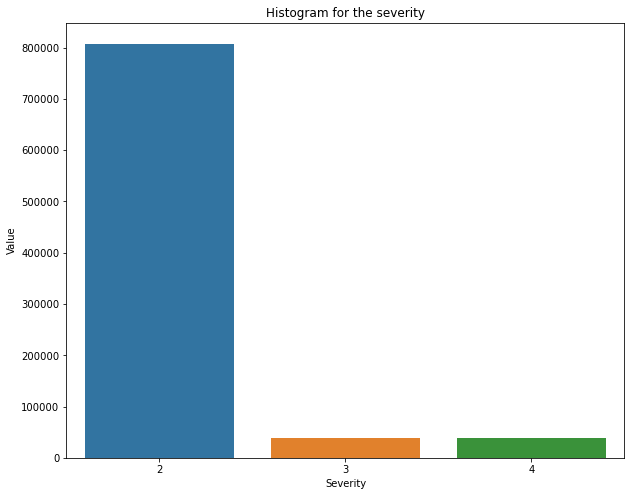

In [17]:
severity_counts = df["Severity"].value_counts()

plt.figure(figsize=(10, 8))
plt.title("Histogram for the severity")
sns.barplot(severity_counts.index, severity_counts.values)
plt.xlabel("Severity")
plt.ylabel("Value")
plt.show()

In [18]:
size = len(df[df["Severity"]==2].index)
new_df = pd.DataFrame()
for i in range(2,5):
    S = df[df["Severity"]==i]
    new_df = new_df.append(S.sample(size, random_state=42, replace = True))
df = new_df

C:\Users\arpit\AppData\Local\Temp\ipykernel_16728\950773131.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(S.sample(size, random_state=42, replace = True))
C:\Users\arpit\AppData\Local\Temp\ipykernel_16728\950773131.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(S.sample(size, random_state=42, replace = True))
C:\Users\arpit\AppData\Local\Temp\ipykernel_16728\950773131.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(S.sample(size, random_state=42, replace = True))


C:\Users\arpit\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


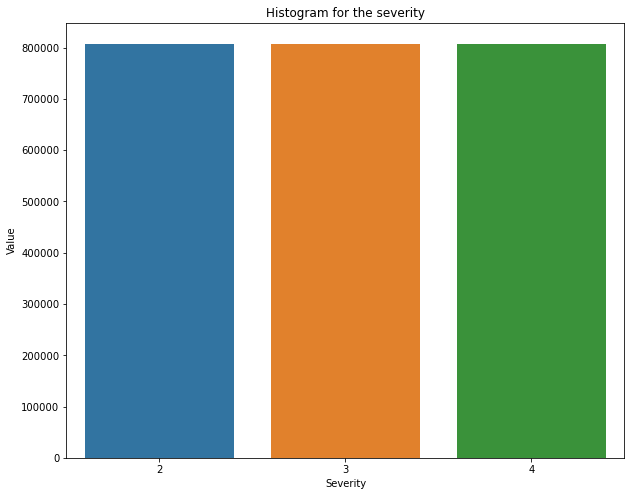

In [19]:
severity_counts = df["Severity"].value_counts()
plt.figure(figsize=(10, 8))
plt.title("Histogram for the severity")
sns.barplot(severity_counts.index, severity_counts.values)
plt.xlabel("Severity")
plt.ylabel("Value")
plt.show()

## Feature Normalization

In [20]:
list(df.columns)

['Severity',
 'Start_Lat',
 'Start_Lng',
 'Distance(mi)',
 'Side',
 'City',
 'Temperature(F)',
 'Humidity(%)',
 'Pressure(in)',
 'Visibility(mi)',
 'Wind_Direction',
 'Wind_Speed(mph)',
 'Precipitation(in)',
 'Weather_Condition',
 'Amenity',
 'Bump',
 'Crossing',
 'Give_Way',
 'Junction',
 'No_Exit',
 'Railway',
 'Roundabout',
 'Station',
 'Stop',
 'Traffic_Calming',
 'Traffic_Signal',
 'Civil_Twilight',
 'Year',
 'Month',
 'Weekday',
 'Day',
 'Hour',
 'Minute']

In [21]:
scaler = MinMaxScaler()
features = ['Temperature(F)','Distance(mi)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)','Start_Lng','Start_Lat','Year', 'Month','Weekday','Day','Hour','Minute']
df[features] = scaler.fit_transform(df[features])
df.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Side,City,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),...,Stop,Traffic_Calming,Traffic_Signal,Civil_Twilight,Year,Month,Weekday,Day,Hour,Minute
177597,2,0.721820,0.930401,0.000000,R,Canton,0.321101,0.929293,0.515480,0.008473,...,False,False,False,Day,0.142857,0.272727,0.666667,0.666667,0.652174,1.000000
868082,2,0.539315,0.036794,0.000152,R,San Francisco,0.371560,0.636364,0.514964,0.089598,...,False,False,False,Day,0.714286,1.000000,0.166667,0.200000,0.652174,0.237288
192167,2,0.139897,0.732762,0.002699,R,Tampa,0.487156,0.787879,0.514792,0.089598,...,False,False,False,Day,0.142857,0.363636,0.166667,0.733333,0.434783,0.457627
480084,2,0.474488,0.497826,0.000099,L,Tulsa,0.472477,0.717172,0.501204,0.089598,...,False,False,True,Night,0.714286,0.727273,0.833333,0.100000,0.130435,0.440678
354360,2,0.425242,0.756268,0.001729,R,Rock Hill,0.408257,0.383838,0.502236,0.089598,...,False,False,False,Night,0.714286,0.818182,0.833333,0.500000,0.826087,0.271186


In [22]:
cat_features = set(["Side", "City", "Wind_Direction", "Weather_Condition", "Civil_Twilight"])

for cat in cat_features:
    df[cat] = df[cat].astype("category")

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2423187 entries, 177597 to 566477
Data columns (total 33 columns):
 #   Column             Dtype   
---  ------             -----   
 0   Severity           int64   
 1   Start_Lat          float64 
 2   Start_Lng          float64 
 3   Distance(mi)       float64 
 4   Side               category
 5   City               category
 6   Temperature(F)     float64 
 7   Humidity(%)        float64 
 8   Pressure(in)       float64 
 9   Visibility(mi)     float64 
 10  Wind_Direction     category
 11  Wind_Speed(mph)    float64 
 12  Precipitation(in)  float64 
 13  Weather_Condition  category
 14  Amenity            bool    
 15  Bump               bool    
 16  Crossing           bool    
 17  Give_Way           bool    
 18  Junction           bool    
 19  No_Exit            bool    
 20  Railway            bool    
 21  Roundabout         bool    
 22  Station            bool    
 23  Stop               bool    
 24  Traffic_Calming    b

In [23]:
print("Unique classes for each categorical feature:")
for cat in cat_features:
    print("{:15s}".format(cat), "\t", len(df[cat].unique()))

Unique classes for each categorical feature:
Side            	 2
Weather_Condition 	 11
Civil_Twilight  	 2
City            	 9111
Wind_Direction  	 10


In [24]:
df = df.replace([True, False], [1, 0])

df.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Side,City,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),...,Stop,Traffic_Calming,Traffic_Signal,Civil_Twilight,Year,Month,Weekday,Day,Hour,Minute
177597,2,0.721820,0.930401,0.000000,R,Canton,0.321101,0.929293,0.515480,0.008473,...,0,0,0,Day,0.142857,0.272727,0.666667,0.666667,0.652174,1.000000
868082,2,0.539315,0.036794,0.000152,R,San Francisco,0.371560,0.636364,0.514964,0.089598,...,0,0,0,Day,0.714286,1.000000,0.166667,0.200000,0.652174,0.237288
192167,2,0.139897,0.732762,0.002699,R,Tampa,0.487156,0.787879,0.514792,0.089598,...,0,0,0,Day,0.142857,0.363636,0.166667,0.733333,0.434783,0.457627
480084,2,0.474488,0.497826,0.000099,L,Tulsa,0.472477,0.717172,0.501204,0.089598,...,0,0,1,Night,0.714286,0.727273,0.833333,0.100000,0.130435,0.440678
354360,2,0.425242,0.756268,0.001729,R,Rock Hill,0.408257,0.383838,0.502236,0.089598,...,0,0,0,Night,0.714286,0.818182,0.833333,0.500000,0.826087,0.271186


In [25]:
# Remove city because it will be encoded later
en_cols = cat_features - set(["City"])

df = pd.get_dummies(df, columns=en_cols, drop_first=True)

df.head()

C:\Users\arpit\AppData\Local\Temp\ipykernel_16728\1471872662.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=en_cols, drop_first=True)


,Severity,Start_Lat,Start_Lng,Distance(mi),City,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),...,Wind_Direction_E,Wind_Direction_N,Wind_Direction_NE,Wind_Direction_NW,Wind_Direction_S,Wind_Direction_SE,Wind_Direction_SW,Wind_Direction_Variable,Wind_Direction_W,Side_R
177597,2,0.721820,0.930401,0.000000,Canton,0.321101,0.929293,0.515480,0.008473,0.014163,...,1,0,0,0,0,0,0,0,0,1
868082,2,0.539315,0.036794,0.000152,San Francisco,0.371560,0.636364,0.514964,0.089598,0.003695,...,0,0,0,0,0,1,0,0,0,1
192167,2,0.139897,0.732762,0.002699,Tampa,0.487156,0.787879,0.514792,0.089598,0.014163,...,0,0,0,0,1,0,0,0,0,1
480084,2,0.474488,0.497826,0.000099,Tulsa,0.472477,0.717172,0.501204,0.089598,0.014778,...,0,0,0,0,1,0,0,0,0,0
354360,2,0.425242,0.756268,0.001729,Rock Hill,0.408257,0.383838,0.502236,0.089598,0.009852,...,0,0,0,1,0,0,0,0,0,1


In [26]:
binary_encoder = ce.binary.BinaryEncoder()

city_binary_enc = binary_encoder.fit_transform(df["City"])
city_binary_enc

,City_0,City_1,City_2,City_3,City_4,City_5,City_6,City_7,City_8,City_9,City_10,City_11,City_12,City_13
177597,0,0,0,0,0,0,0,0,0,0,0,0,0,1
868082,0,0,0,0,0,0,0,0,0,0,0,0,1,0
192167,0,0,0,0,0,0,0,0,0,0,0,0,1,1
480084,0,0,0,0,0,0,0,0,0,0,0,1,0,0
354360,0,0,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201626,0,0,0,0,0,0,0,0,1,1,1,1,1,0
109181,0,0,0,0,1,0,0,1,0,0,1,1,1,0
154222,1,0,0,0,0,0,0,0,0,1,1,1,0,1
1003086,0,0,0,0,0,1,1,0,1,1,0,1,1,0


In [27]:
df = pd.concat([df, city_binary_enc], axis=1).drop("City", axis=1)

df.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),...,City_4,City_5,City_6,City_7,City_8,City_9,City_10,City_11,City_12,City_13
177597,2,0.721820,0.930401,0.000000,0.321101,0.929293,0.515480,0.008473,0.014163,0.00082,...,0,0,0,0,0,0,0,0,0,1
868082,2,0.539315,0.036794,0.000152,0.371560,0.636364,0.514964,0.089598,0.003695,0.00000,...,0,0,0,0,0,0,0,0,1,0
192167,2,0.139897,0.732762,0.002699,0.487156,0.787879,0.514792,0.089598,0.014163,0.00082,...,0,0,0,0,0,0,0,0,1,1
480084,2,0.474488,0.497826,0.000099,0.472477,0.717172,0.501204,0.089598,0.014778,0.00000,...,0,0,0,0,0,0,0,1,0,0
354360,2,0.425242,0.756268,0.001729,0.408257,0.383838,0.502236,0.089598,0.009852,0.00000,...,0,0,0,0,0,0,0,1,0,1


## Modelling

In [28]:
# Metrics dictionary
accuracy = dict()
precision = dict()
recall = dict()
f1 = dict()
fpr = dict()
tpr = dict()

In [29]:
# Train/Validation - Test split
df, X_test = train_test_split(df, test_size=.2, random_state=42)
print(df.shape, X_test.shape)

(1938549, 63) (484638, 63)


## Decision Tree

In [30]:
sample = df
Y_sample = sample["Severity"]
X_sample = sample.drop("Severity", axis=1)

X_train, X_validate, Y_train, Y_validate = train_test_split(X_sample, Y_sample, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_validate.shape, Y_validate.shape)

(1453911, 62) (1453911,)
(484638, 62) (484638,)


In [31]:
dtc = DecisionTreeClassifier(random_state=42)
parameters = [{"criterion": ["gini", "entropy"], "max_depth": [5, 10, 15, 30]}]
grid = GridSearchCV(dtc, parameters, verbose=5, n_jobs=-1)
grid.fit(X_train, Y_train)

print("Best parameters scores:")
print(grid.best_params_)
print("Train score:", grid.score(X_train, Y_train))
print("Validation score:", grid.score(X_validate, Y_validate))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters scores:
{'criterion': 'entropy', 'max_depth': 30}
Train score: 0.9908144308695649
Validation score: 0.9756478031025219


In [32]:
print("Default scores:")
dtc.fit(X_train, Y_train)
print("Train score:", dtc.score(X_train, Y_train))
print("Validation score:", dtc.score(X_validate, Y_validate))

Default scores:
Train score: 0.9995735639939446
Validation score: 0.9835423553250054


In [33]:
pd.DataFrame(grid.cv_results_).sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,107.704515,11.249442,0.388630,0.064325,entropy,30,"{'criterion': 'entropy', 'max_depth': 30}",0.973272,0.972577,0.972969,0.972233,0.971793,0.972569,0.000523,1
3,135.490110,3.988884,0.686695,0.069161,gini,30,"{'criterion': 'gini', 'max_depth': 30}",0.968867,0.968870,0.968361,0.968392,0.967539,0.968406,0.000486,2
2,97.729690,0.505075,0.456755,0.028027,gini,15,"{'criterion': 'gini', 'max_depth': 15}",0.822885,0.820439,0.822864,0.820123,0.817527,0.820768,0.001995,3
6,104.822717,2.256482,0.460339,0.056692,entropy,15,"{'criterion': 'entropy', 'max_depth': 15}",0.810116,0.809104,0.807529,0.809950,0.807798,0.808900,0.001069,4
1,74.364462,3.571071,0.433108,0.052545,gini,10,"{'criterion': 'gini', 'max_depth': 10}",0.746443,0.745335,0.746563,0.746920,0.747137,0.746480,0.000624,5
5,81.024772,1.433028,0.437123,0.023819,entropy,10,"{'criterion': 'entropy', 'max_depth': 10}",0.741054,0.740575,0.741573,0.742666,0.741277,0.741429,0.000699,6
0,44.244861,0.405149,0.396946,0.052854,gini,5,"{'criterion': 'gini', 'max_depth': 5}",0.699625,0.701419,0.701017,0.700855,0.699565,0.700496,0.000759,7
4,39.647322,2.183763,0.339781,0.025096,entropy,5,"{'criterion': 'entropy', 'max_depth': 5}",0.696196,0.698121,0.695972,0.698413,0.694482,0.696637,0.001459,8


In [34]:
Y_pred = dtc.predict(X_validate)

accuracy["Decision Tree"] = accuracy_score(Y_validate, Y_pred)
f1["Decision Tree"] = f1_score(Y_validate, Y_pred, average="macro")

print(classification_report(Y_train, dtc.predict(X_train)))
print(classification_report(Y_validate, Y_pred))

              precision    recall  f1-score   support

           2       1.00      1.00      1.00    484811
           3       1.00      1.00      1.00    484052
           4       1.00      1.00      1.00    485048

    accuracy                           1.00   1453911
   macro avg       1.00      1.00      1.00   1453911
weighted avg       1.00      1.00      1.00   1453911

              precision    recall  f1-score   support

           2       1.00      0.95      0.97    161730
           3       0.98      1.00      0.99    161711
           4       0.97      1.00      0.99    161197

    accuracy                           0.98    484638
   macro avg       0.98      0.98      0.98    484638
weighted avg       0.98      0.98      0.98    484638



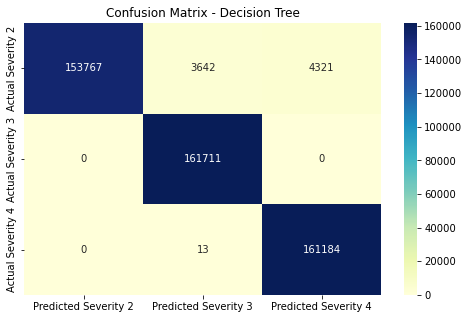

In [35]:
Y_pred = dtc.predict(X_validate)
confmat = confusion_matrix(y_true=Y_validate, y_pred=Y_pred)

index = ["Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

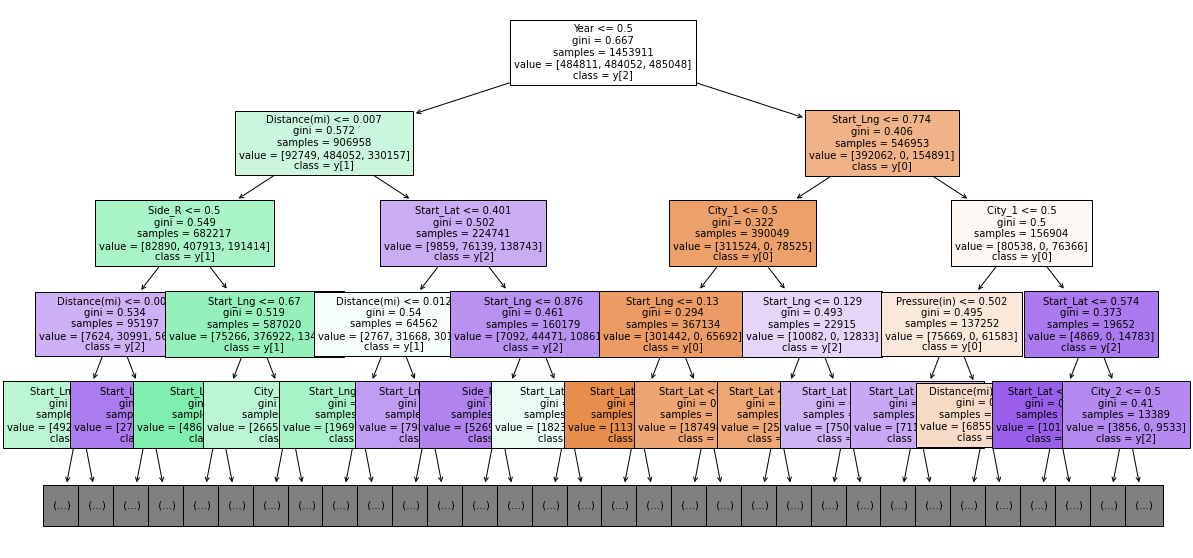

In [37]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(dtc, max_depth=4, fontsize=10, feature_names=X_train.columns.to_list(), class_names = True, filled=True)
plt.show()

## Naive Bayes

In [38]:
sample = df
Y_sample = sample["Severity"]
X_sample = sample.drop("Severity", axis=1)

X_train, X_validate, Y_train, Y_validate = train_test_split(X_sample, Y_sample, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_validate.shape, Y_validate.shape)

(1453911, 62) (1453911,)
(484638, 62) (484638,)


In [39]:
gnb = GaussianNB()
gnb.fit(X_train, Y_train)

print("Train score:", gnb.score(X_train, Y_train))
print("Validation score:", gnb.score(X_validate, Y_validate))

Train score: 0.5165928313356182
Validation score: 0.5164452643003644


In [40]:
Y_pred = gnb.predict(X_validate)

accuracy["Gaussian Naive Bayes"] = accuracy_score(Y_validate, Y_pred)
f1["Gaussian Naive Bayes"] = f1_score(Y_validate, Y_pred, average="macro")

print(classification_report(Y_train, gnb.predict(X_train)))
print(classification_report(Y_validate, Y_pred))

              precision    recall  f1-score   support

           2       0.59      0.08      0.14    484811
           3       0.64      0.81      0.71    484052
           4       0.41      0.66      0.51    485048

    accuracy                           0.52   1453911
   macro avg       0.55      0.52      0.45   1453911
weighted avg       0.55      0.52      0.45   1453911

              precision    recall  f1-score   support

           2       0.59      0.08      0.14    161730
           3       0.64      0.81      0.71    161711
           4       0.41      0.66      0.51    161197

    accuracy                           0.52    484638
   macro avg       0.55      0.52      0.45    484638
weighted avg       0.55      0.52      0.45    484638



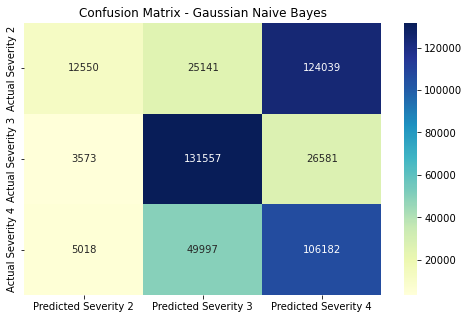

In [41]:
Y_pred = gnb.predict(X_validate)
confmat = confusion_matrix(y_true=Y_validate, y_pred=Y_pred)

index = ["Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Gaussian Naive Bayes")
plt.show()

In [42]:
bnb = BernoulliNB()
bnb.fit(X_train, Y_train)

print("Train score:", bnb.score(X_train, Y_train))
print("Validation score:", bnb.score(X_validate, Y_validate))

Train score: 0.6443523709498037
Validation score: 0.6445346836195264


In [43]:
Y_pred = bnb.predict(X_validate)

accuracy["Gaussian Naive Bayes"] = accuracy_score(Y_validate, Y_pred)
f1["Gaussian Naive Bayes"] = f1_score(Y_validate, Y_pred, average="macro")

print(classification_report(Y_train, bnb.predict(X_train)))
print(classification_report(Y_validate, Y_pred))

              precision    recall  f1-score   support

           2       0.71      0.71      0.71    484811
           3       0.61      0.78      0.69    484052
           4       0.62      0.45      0.52    485048

    accuracy                           0.64   1453911
   macro avg       0.64      0.64      0.64   1453911
weighted avg       0.64      0.64      0.64   1453911

              precision    recall  f1-score   support

           2       0.71      0.71      0.71    161730
           3       0.61      0.78      0.69    161711
           4       0.61      0.45      0.52    161197

    accuracy                           0.64    484638
   macro avg       0.64      0.64      0.64    484638
weighted avg       0.64      0.64      0.64    484638



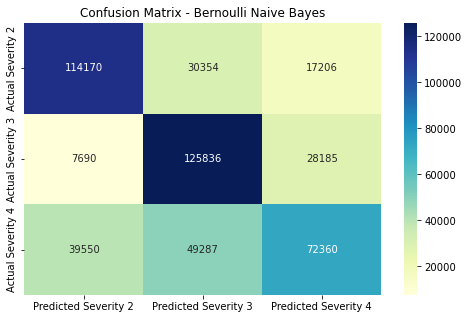

In [44]:
Y_pred = bnb.predict(X_validate)
confmat = confusion_matrix(y_true=Y_validate, y_pred=Y_pred)

index = ["Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Bernoulli Naive Bayes")
plt.show()

## Multilayer Perceptron

In [45]:
sample = df
Y_sample = sample["Severity"]
X_sample = sample.drop("Severity", axis=1)

X_train, X_validate, Y_train, Y_validate = train_test_split(X_sample, Y_sample, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_validate.shape, Y_validate.shape)

(1453911, 62) (1453911,)
(484638, 62) (484638,)


In [46]:
mlp = MLPClassifier(random_state=42, verbose=False)
parameters = [{"hidden_layer_sizes": [(64, 32), (32, 64, 32)], "max_iter": [200], "solver": ["sgd", "adam"], "activation": ["tanh", "relu"]}]
grid = GridSearchCV(mlp, parameters, verbose=5, n_jobs=-1)

sample = df.sample(10_000, random_state=42)
Y_sample = sample["Severity"]
X_sample = sample.drop("Severity", axis=1)
grid.fit(X_sample, Y_sample)

print("Best parameters scores:")
print(grid.best_params_)
print("Train score:", grid.score(X_train, Y_train))
print("Validation score:", grid.score(X_validate, Y_validate))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\arpit\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters scores:
{'activation': 'relu', 'hidden_layer_sizes': (64, 32), 'max_iter': 200, 'solver': 'sgd'}
Train score: 0.6779507136269002
Validation score: 0.6795752706143554


In [47]:
print("Default scores:")
mlp.fit(X_train, Y_train)
print("Train score:", mlp.score(X_train, Y_train))
print("Validation score:", mlp.score(X_validate, Y_validate))

Default scores:
Train score: 0.7588951455763111
Validation score: 0.7558961534176024


In [48]:
pd.DataFrame(grid.cv_results_).sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,param_max_iter,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,24.814801,0.764539,0.015610,0.001886,relu,"(64, 32)",200,sgd,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.6900,0.6620,0.6855,0.6770,0.6745,0.6778,0.009688,1
2,29.232854,0.562911,0.024928,0.008759,tanh,"(32, 64, 32)",200,sgd,"{'activation': 'tanh', 'hidden_layer_sizes': (...",0.6870,0.6645,0.6765,0.6710,0.6720,0.6742,0.007461,2
0,20.478618,0.204158,0.024169,0.011867,tanh,"(64, 32)",200,sgd,"{'activation': 'tanh', 'hidden_layer_sizes': (...",0.6815,0.6610,0.6745,0.6755,0.6755,0.6736,0.006771,3
6,34.620709,1.053665,0.020328,0.003479,relu,"(32, 64, 32)",200,sgd,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.6805,0.6595,0.6740,0.6700,0.6680,0.6704,0.006924,4
3,33.252152,0.550353,0.022403,0.002154,tanh,"(32, 64, 32)",200,adam,"{'activation': 'tanh', 'hidden_layer_sizes': (...",0.6660,0.6475,0.6635,0.6440,0.6525,0.6547,0.008675,5
1,24.755938,1.885094,0.027477,0.014357,tanh,"(64, 32)",200,adam,"{'activation': 'tanh', 'hidden_layer_sizes': (...",0.6450,0.6415,0.6605,0.6510,0.6405,0.6477,0.007380,6
7,34.327839,1.701619,0.011740,0.002528,relu,"(32, 64, 32)",200,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.6490,0.6275,0.6585,0.6515,0.6410,0.6455,0.010597,7
5,29.210409,1.220044,0.023562,0.005895,relu,"(64, 32)",200,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.6350,0.6300,0.6380,0.6255,0.6400,0.6337,0.005307,8


In [49]:
Y_pred = mlp.predict(X_validate)

accuracy["Multi Layer Perceptron"] = accuracy_score(Y_validate, Y_pred)
f1["Multi Layer Perceptron"] = f1_score(Y_validate, Y_pred, average="macro")

print(classification_report(Y_train, mlp.predict(X_train)))
print(classification_report(Y_validate, Y_pred))

              precision    recall  f1-score   support

           2       0.80      0.77      0.79    484811
           3       0.71      0.90      0.80    484052
           4       0.78      0.60      0.68    485048

    accuracy                           0.76   1453911
   macro avg       0.77      0.76      0.75   1453911
weighted avg       0.77      0.76      0.75   1453911

              precision    recall  f1-score   support

           2       0.80      0.77      0.78    161730
           3       0.71      0.90      0.79    161711
           4       0.77      0.60      0.67    161197

    accuracy                           0.76    484638
   macro avg       0.76      0.76      0.75    484638
weighted avg       0.76      0.76      0.75    484638



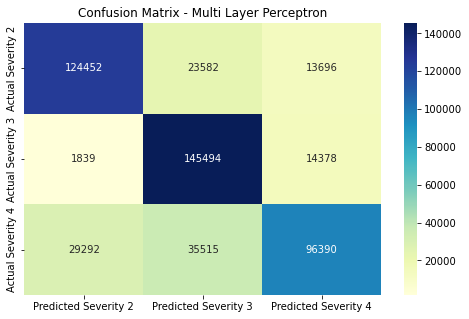

In [50]:
Y_pred = mlp.predict(X_validate)
confmat = confusion_matrix(y_true=Y_validate, y_pred=Y_pred)

index = ["Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Multi Layer Perceptron")
plt.show()

C:\Users\arpit\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


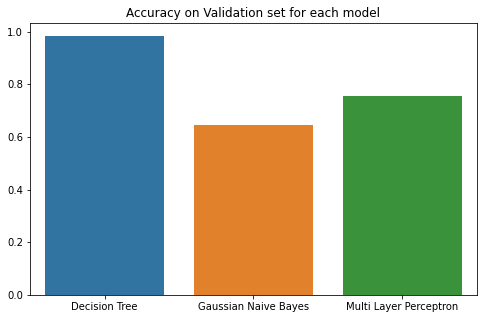

In [51]:
plt.figure(figsize=(8, 5))
plt.title("Accuracy on Validation set for each model")
sns.barplot(list(range(len(accuracy))), list(accuracy.values()))
plt.xticks(range(len(accuracy)), labels=accuracy.keys())
plt.show()

C:\Users\arpit\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


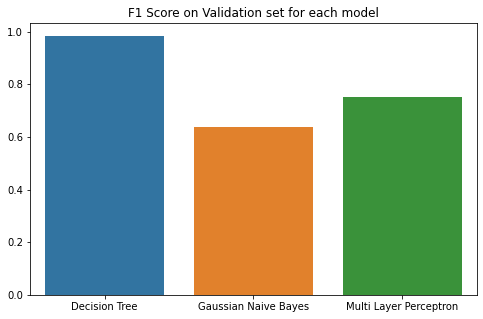

In [52]:
plt.figure(figsize=(8,5))
plt.title("F1 Score on Validation set for each model")
sns.barplot(list(range(len(f1))), list(f1.values()))
plt.xticks(range(len(f1)), labels=f1.keys())
plt.show()